# SegFormer 单图推理 + 可视化 + 类别统计

依赖：`mindspore`, `mindnlp`, `Pillow`, `numpy`, `matplotlib`, `pandas`。

In [1]:
import kagglehub
import os

# 只需改这两个：数据集句柄 + 想要的文件相对路径
DATASET = "ipythonx/ade20k-scene-parsing"
IMG_REL = "ADEChallengeData2016/images/validation/ADE_val_00000001.jpg"      # 一张验证集图片
ANN_REL = "ADEChallengeData2016/annotations/validation/ADE_val_00000001.png" # 对应标注（可选）

# 如果本机非 Kaggle 环境，且需要鉴权，可选择执行：
# kagglehub.login()  # 或使用环境变量/ ~/.kaggle/kaggle.json

# 仅下载指定的这张图片
img_path = kagglehub.dataset_download(DATASET, path=IMG_REL)
print("Image saved at:", img_path)

# （可选）下载对应标注
try:
    ann_path = kagglehub.dataset_download(DATASET, path=ANN_REL)
    print("Annotation saved at:", ann_path)
except Exception as e:
    print("Annotation not downloaded:", e)


Image saved at: /home/HwHiAiUser/.cache/kagglehub/datasets/ipythonx/ade20k-scene-parsing/versions/2/ADEChallengeData2016/images/validation/ADE_val_00000001.jpg
Annotation saved at: /home/HwHiAiUser/.cache/kagglehub/datasets/ipythonx/ade20k-scene-parsing/versions/2/ADEChallengeData2016/annotations/validation/ADE_val_00000001.png


In [2]:
from mindspore import Tensor, Parameter
import mindspore as ms
from mindspore import dtype as mstype
from mindspore import ops
try:
    # mindnlp Module base
    from mindnlp.core.nn import Module as _BaseModule
except Exception:
    # Fallback to MindSpore Cell if needed
    from mindspore.nn import Cell as _BaseModule

class _FixedAffine2d(_BaseModule):
    def __init__(self, scale: Tensor, bias: Tensor):
        super().__init__()
        # Keep as Parameters (no grad needed at eval)
        self.scale = Parameter(scale.astype(mstype.float16), name='scale')
        self.bias = Parameter(bias.astype(mstype.float16), name='bias')
    def forward(self, x):
        # Broadcast [C] -> [1,C,1,1]
        s = ops.reshape(self.scale, (1, -1, 1, 1))
        b = ops.reshape(self.bias, (1, -1, 1, 1))
        return x * s + b

def _extract_bn_params(bn):
    # Try common attribute names across mindnlp/mindspore
    gamma = getattr(bn, 'weight', None)
    beta  = getattr(bn, 'bias', None)
    running_mean = getattr(bn, 'running_mean', None)
    running_var  = getattr(bn, 'running_var', None)
    eps = getattr(bn, 'eps', 1e-5)
    # Some variants use different names
    if gamma is None:
        gamma = getattr(bn, 'gamma', None)
    if beta is None:
        beta = getattr(bn, 'beta', None)
    return gamma, beta, running_mean, running_var, eps

def bn_to_affine(bn):
    gamma, beta, mean, var, eps = _extract_bn_params(bn)
    if any(v is None for v in (gamma, beta, mean, var)):
        raise RuntimeError('BN parameters missing; cannot fold to affine.')
    # Compute per-channel affine: scale = gamma / sqrt(var+eps), bias = beta - mean*scale
    scale = gamma / ops.sqrt(var + eps)
    bias  = beta - mean * scale
    return _FixedAffine2d(scale, bias)

def replace_bn_with_affine(model):
    # Recursively traverse children and replace BN modules by class name to avoid hard deps
    def _is_bn(m):
        name = m.__class__.__name__
        return name in ('BatchNorm2d','SyncBatchNorm','BatchNorm')
    def _replace_in_parent(parent):
        # Attempt via named_children style API
        try:
            for name, child in list(parent.named_children()):
                if _is_bn(child):
                    affine = bn_to_affine(child)
                    setattr(parent, name, affine)
                else:
                    _replace_in_parent(child)
            return
        except Exception:
            pass
        # Fallback: scan attributes
        for name in dir(parent):
            try:
                child = getattr(parent, name)
            except Exception:
                continue
            # Skip non-modules quickly
            if not hasattr(child, '__class__'):
                continue
            if _is_bn(child):
                affine = bn_to_affine(child)
                try:
                    setattr(parent, name, affine)
                except Exception:
                    pass
            else:
                # Recurse if it looks like a submodule
                if hasattr(child, 'named_children'):
                    try:
                        _replace_in_parent(child)
                    except Exception:
                        pass
    _replace_in_parent(model)


[WARNING] DEVICE(6861,e7ffd2e71020,python):2025-11-05-10:10:07.998.216 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclprofGetSupportedFeaturesV2 failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libmsprofiler.so: undefined symbol: aclprofGetSupportedFeaturesV2
[WARNING] DEVICE(6861,e7ffd2e71020,python):2025-11-05-10:10:07.998.346 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclrtEventGetTimestamp failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclrtEventGetTimestamp
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  re

In [3]:
# === 基本配置 ===
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import ops, context
from mindnlp.transformers import (
    SegformerForSemanticSegmentation,
    SegformerImageProcessor,
)

MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"
NUM_CLASSES = 150

image_path = img_path
out_dir = "./segformer_single_out"
device = "Ascend"  # 可选："GPU" / "CPU"

try:
    ms.set_device(device)
except Exception:
    context.set_context(mode=context.GRAPH_MODE, device_target=device)
os.makedirs(out_dir, exist_ok=True)

print(f"[Info] Device: {device}")
print(f"[Info] Out dir: {os.path.abspath(out_dir)}")


[Info] Device: Ascend
[Info] Out dir: /home/HwHiAiUser/Seformer/segformer_single_out


In [4]:
# === 辅助函数 ===
def palette_150():
    rng = np.random.default_rng(0)
    pal = rng.integers(0, 256, size=(NUM_CLASSES, 3), dtype=np.uint8)
    pal[0] = np.array([0, 0, 0], dtype=np.uint8)
    return pal

def logits_to_pred_np(logits):
    try:
        pred = ops.argmax(logits, 1)
    except TypeError:
        pred = ops.Argmax(axis=1)(logits)
    pred_np = pred.asnumpy().astype(np.uint8)
    return pred_np[0] if pred_np.ndim == 3 else pred_np

def save_pred_mask(pred_np, mask_path, vis_path=None):
    Image.fromarray(pred_np.astype(np.uint8), mode="L").save(mask_path)
    if vis_path:
        pal = palette_150()
        color = pal[pred_np.clip(0, NUM_CLASSES - 1)]
        Image.fromarray(color, mode="RGB").save(vis_path)


In [5]:
from mindspore import dtype as mstype
from mindspore import ops
def to_fp16_model(net):
    for p in net.get_parameters():
        if getattr(p, 'dtype', None) != mstype.float16:
            p.set_dtype(mstype.float16)
    return net
# === 加载模型与处理器 ===
print("[Info] Loading model & processor ...")
processor = SegformerImageProcessor.from_pretrained(MODEL_NAME)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME)

replace_bn_with_affine(model)
to_fp16_model(model)
model.set_train(False)
print("[OK] Model ready.")


[Info] Loading model & processor ...


/home/HwHiAiUser/.local/lib/python3.9/site-packages/mindnlp/transformers/models/segformer/image_processing_segformer.py:129: FutureWarning: The `reduce_labels` parameter is deprecated. Please use `do_reduce_labels` instead.
  warnings.warn(


[OK] Model ready.


In [6]:
# === 单图推理 ===
assert os.path.isfile(image_path), f"未找到图片：{image_path}"
img = Image.open(image_path).convert("RGB")
inputs = processor(img, return_tensors="ms")
outputs = model(ops.Cast()(inputs["pixel_values"], mstype.float16))

pred_np = logits_to_pred_np(outputs.logits)
print(f"[Info] Image size (W,H): {img.size}")
print(f"[Info] Pred shape (H,W): {pred_np.shape}")

stem = os.path.splitext(os.path.basename(image_path))[0]
mask_path = os.path.join(out_dir, f"{stem}.png")
vis_path  = os.path.join(out_dir, f"{stem}.jpg")
save_pred_mask(pred_np, mask_path, vis_path)

ids, counts = np.unique(pred_np, return_counts=True)
print(f"[Info] Predicted {len(ids)} classes. Top few:")
for k, c in list(zip(ids.tolist(), counts.tolist()))[:10]:
    print(f"  class {int(k):3d}: {int(c)} px")

print("[OK] Saved files:")
print("  Mask:", os.path.abspath(mask_path))
print("  Vis :", os.path.abspath(vis_path))


[Info] Image size (W,H): (683, 512)
[Info] Pred shape (H,W): (128, 128)
[Info] Predicted 8 classes. Top few:
  class   0: 306 px
  class   1: 609 px
  class   2: 6366 px
  class   4: 485 px
  class   9: 2613 px
  class  17: 102 px
  class  25: 5823 px
  class  52: 80 px
[OK] Saved files:
  Mask: /home/HwHiAiUser/Seformer/segformer_single_out/ADE_val_00000001.png
  Vis : /home/HwHiAiUser/Seformer/segformer_single_out/ADE_val_00000001.jpg


Text(0.5, 1.0, 'SegFormer (color)')

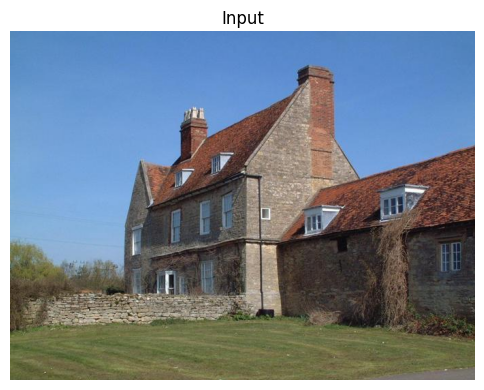

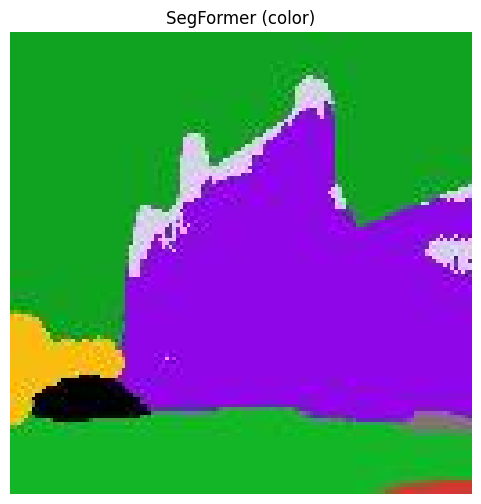

In [7]:
# === 可视化（每张图单独绘制） ===
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Input")

vis_img = Image.open(vis_path)
plt.figure(figsize=(6, 6))
plt.imshow(vis_img)
plt.axis("off")
plt.title("SegFormer (color)")


## 类别映射与统计输出（来自 `model.config.id2label`）

将预测出现的类别 ID 映射到语义名称，并保存为 CSV（可选 XLSX）。

In [8]:
import pandas as pd

# 模型自带标签映射（ADE20K 的 150 类），如缺失则用占位名称
id2label = getattr(model.config, "id2label", {})
if not id2label:
    print("[Warn] 模型未提供 id2label；将以 class_x 代替名称")

ids, counts = np.unique(pred_np, return_counts=True)
total = counts.sum()

rows = []
for i, cnt in zip(ids.tolist(), counts.tolist()):
    name = id2label.get(int(i), f"class_{int(i)}")
    rows.append({
        "class_id": int(i),
        "class_name": name,
        "pixels": int(cnt),
        "percent": float(cnt) / float(total) if total else 0.0
    })

df = pd.DataFrame(rows).sort_values("pixels", ascending=False).reset_index(drop=True)
display(df)

csv_path = os.path.join(out_dir, f"{stem}_class_stats.csv")
df.to_csv(csv_path, index=False)
print("[OK] CSV saved to:", os.path.abspath(csv_path))

try:
    xlsx_path = os.path.join(out_dir, f"{stem}_class_stats.xlsx")
    df.to_excel(xlsx_path, index=False)
    print("[OK] Excel saved to:", os.path.abspath(xlsx_path))
except Exception as e:
    print("[Info] Excel save skipped:", e)


,class_id,class_name,pixels,percent
0,2,sky,6366,0.388550
1,25,house,5823,0.355408
2,9,grass,2613,0.159485
3,1,building,609,0.037170
4,4,tree,485,0.029602
5,0,wall,306,0.018677
6,17,plant,102,0.006226
7,52,path,80,0.004883


[OK] CSV saved to: /home/HwHiAiUser/Seformer/segformer_single_out/ADE_val_00000001_class_stats.csv
[Info] Excel save skipped: No module named 'openpyxl'
